##Импорт библиотек

In [ ]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными

import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
from matplotlib.colors import ListedColormap # функция библиотеки Matplotlib, которая генерирует цветовую карту

from sklearn.datasets import make_moons, make_circles, make_classification # генерируемые наборы данных

from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и тестовую выборку
# но в исполнении scikit-learn

import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

In [ ]:
plt.style.use('dark_background')

## Класс линейной регрессии

In [ ]:
class LinearRegression():
    def __init__(self,
                 learning_rate = 0.5,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        self.n_batches = n_batches


    #---------------------------------
    def forward(self, X):
        # умножаем признаки на веса
        return np.dot(X, self.weights)

    #---------------------------------
    def loss(self,yhat, y):
        # расчет функции потерь
        return np.square(yhat - y).sum()/y.size

    #---------------------------------
    def grad_step(self,yhat, y, X):
        # расчет градиента
        return 2*np.dot(X.T, (yhat - y)) / y.size

    #---------------------------------
    def update(self):
        # обновление весов
        return self.weights - self.lr*self.grad

    #---------------------------------
    def init(self, weights_size):
        # инициализируем веса
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)

    #---------------------------------
    def predict(self, X):
        # делем предсказание модели
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()

    #---------------------------------
    def score(self, X, y):
        # оценка по коэффициенту детерминации
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

    #---------------------------------
    def fit(self, X, y):
        # обучение модели с учетом разбиения на батчи
        np.random.seed(self.seed)

        if self.weights is None: # если веса не заданы - задаем
            self.weights = self.init(X.shape[1])

        if self.bias is None: # если смещение не задано - задаем
            self.bias    = self.init(1)

        if self.weights.size == X.shape[1]: # если веса заданы, но не добавлено смещение - объединяем
            self.weights = np.append(self.bias,self.weights)

        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:   # проверка на согласование размерности батча и размерности данных
            self.batch_size = y.size

        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size

        for i in range(self.epochs): #циклы обучения, как раньше
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)):

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch)
                self.weights = self.update()
                loss += self.loss(yhat,  y_batch)

                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches

        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        # загрузка батча
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch) # тут мы всегда добавляем смещение
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch

    #---------------------------------
    def add_bias(self, X):
        # добавление смещения
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = 'Кривая обучения'):
        # отрисовка сразу в методе
        fig = go.Figure()
            # рисуем с помощью библиотеки plotly
        fig.add_trace(
                go.Scatter(
                y=self.cost,
                mode='lines+markers',
                name='Реальные данные',

                )
            )
        fig.update_layout(
                    title=title,
                    width=1200,
                    height=600,
                template = "plotly_dark"
                    )

        fig.show()

    #---------------------------------
    def get_w_and_b(self):
        # "новый" метод - который возвращает веса модели и смещение
        return (self.weights[1:], self.bias)

## Класс Эластической регрессии

In [ ]:
class ElasticRegression(LinearRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term

    #---------------------------------
    def update(self):
        # изменяем правило обновление весов
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

## Ввизуализация данных

In [ ]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    """Визуализация двумерных  данных для классификации
    Входные переменные:
    ===========
    ax:
    ds: набор данных, содержащий признаки X и целевые метки y
    name: название графика
    marker: тип маркера - по умолчанию просто круги
    colors: цвета, которые будут использоваться для раскраски разных классов - по умолчанию Красный и Синий
    alpha: прозрачность маркеров
    s: размер маркера (~ квадрат радиуса)
    facecolor:
    """

    X, y = ds # распаковываем признаки и целевые метки в отдельные переменные

    cm_bright = ListedColormap(colors) # формируем цветовую карту из наших цветов
    ax.set_title(name, fontsize = 30) # прописываем название графика
    if facecolor: # если переменная задана - то просто рисуем скатерограмму по признакам с использованием параметров маркеров
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else: # иначе так же рисуем скатерограмму, но без
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)
    # немного красоты и ля аккуратности
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
def vis_weigths(weights):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса
    """
    numbers = np.arange(0,len(weights)) # создаем массив от 0 до количество весов-1
    tick_labels = np.array(['w'+str(num) for num in numbers]) # создаем "названия" весов


    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=1200,
                height=600,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

In [ ]:
def make_binary_clf(N, method = 'line',
                    noises = 0.15,
                    random_state = 42):
    """Создание синтетического набора данных
    для бинарной классификации
    Входные переменные:
    ===========
    N: количество точек
    method: тип набора данных
    noises: коэффициент ~ сила шума
    random_state: фиксированный сид случайных чисел (для повторяемости)
    """
    # фиксируем случайный seed
    if random_state: rng = np.random.RandomState(seed = random_state)

    if method == 'line' or method is None:
        # если выбран метод line (или никакой не задан)
        # то мы создаем набор данных с использованием функции make_classification
        # это будут линейно-разделимые данные
        X, y = make_classification(n_samples=N, # количество точек
                                   n_features=2, # количество признаков
                                   n_redundant=0, # количество бесполезных признаков
                                   n_informative=2,# количество информативных признаков
                                   n_clusters_per_class=1, # количество групп точек на класс
                                   class_sep=2, # количество классов
                                   random_state=random_state # фиксированный сид случайных чисел
                                   )
        X += np.random.randn(*X.shape) *noises # добавляем к признакам случайный шум

    elif method == 'moons':
        # если выбран метод moons
        # то мы создаем набор данных с использованием функции make_moons
        # это будут данные похожие на Инь-Ян
        X, y = make_moons(n_samples=N, # количество точек
                          noise=noises, # уровень шума
                          random_state=random_state # фиксированный сид случайных чисел
                          )

    elif method == 'circles':
        # если выбран метод circles
        # то мы создаем набор данных с использованием функции make_circles
        # это будут данные в виде концентрических окружностей
        X, y = make_circles(n_samples=N, # количество точек
                            noise=noises, # уровень шума
                            factor=0.5, # соотношение радиусов внуренней и внешней окружности
                            random_state=random_state # фиксированный сид случайных чисел
                            )


    return X,y

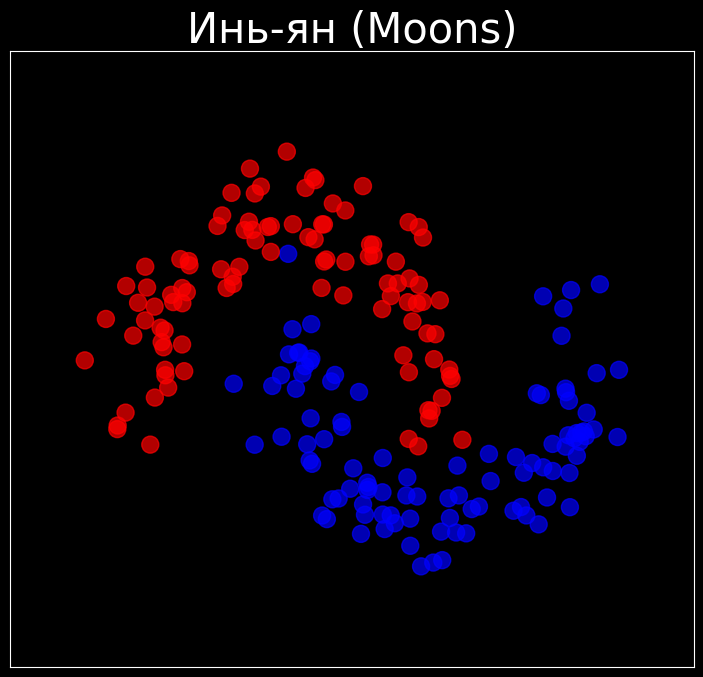

In [ ]:
#@title данные { run: "auto" }
N = 200 #@param {type:"slider", min:50, max:250, step:25}
noises = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}
# слайдерами можно изменять количество точек и уровень шума
# И - Интерактивностб

fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 2)
plot_data(ax,make_binary_clf(N,method = 'moons'),
          'Инь-ян (Moons)')



In [ ]:
def to_class(logit, threshold = 0.7):
    # функция для принятия решения о классификации
    # сравниваем с порогом - если больше, то метка класса 1, если меньше - то 0
    return (logit>=threshold)*1

In [ ]:
_EPS_ = 1e-6
def bce_loss(yhat, y):
    # функция для оценки бинарной кросс-энтропии
    # опять "формула из учебника" с использованием библиотеки numpy
    # небольшой добавка _EPS_ - чтобы был не строго 0 под знаком логарифма. Нам бесконечности не нужны
    return -(y*np.log(yhat + _EPS_)+(1 - y)*np.log(1 - yhat + _EPS_)).mean()

In [ ]:
print('Неопределенность - попали ровно в 0.5 (yhat=0.5, y=1):\t %.3f'%bce_loss(yhat=0.5, y=1))
print('Неопределенность - попали ровно в 0.5 (yhat=0.5, y=0):\t %.3f'%bce_loss(yhat=0.5, y=0))
print('Правильно предсказываем 0 класс (yhat=0, y=0):\t %.3f'%bce_loss(yhat=0.0, y=0))
print('Правильно предсказываем 1 класс (yhat=1, y=1):\t %.3f'%bce_loss(yhat=1, y=1))
print('Неправильно предсказываем 0 класс (yhat=0, y=1):\t %.3f'%bce_loss(yhat=0.0, y=1))
print('Неправильно предсказываем 1 класс (yhat=1, y=0):\t %.3f'%bce_loss(yhat=1, y=0))

Неопределенность - попали ровно в 0.5 (yhat=0.5, y=1):	 0.693
Неопределенность - попали ровно в 0.5 (yhat=0.5, y=0):	 0.693
Правильно предсказываем 0 класс (yhat=0, y=0):	 -0.000
Правильно предсказываем 1 класс (yhat=1, y=1):	 -0.000
Неправильно предсказываем 0 класс (yhat=0, y=1):	 13.816
Неправильно предсказываем 1 класс (yhat=1, y=0):	 13.816


## Класс логистической регрессии

In [ ]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    # унаследуем всё что можно от модели линейной регрессии с эластичной регуляризацией
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100,
                 weights       = None,
                 bias          = None,
                 threshold     = 0.5,
                 batch_size    = 1000,
                 n_batches     = None,
                 random_state  = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь - на бинарную кросс-энтропию
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        # добавки от регуляризации остаются прежде
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term
    #---------------------------------
    def sigmoid(self, z):
        # определение функции сигмоиды
        return 1 / (1 + np.exp(-z))
    #---------------------------------
    def forward(self, X):
        # умножаем признаки на веса и применяем к результату сигмоиду
        return self.sigmoid(np.dot(X, self.weights))
    #---------------------------------
    def to_class(self,logit):
        # классифицируем сравнивая с порогом
        return (logit>=self.threshold)*1
    #---------------------------------
    def predict(self, X):
        # предсказание модели
        # в этот раз в два этапа
        yhat = self.forward(self.add_bias(X)) # 1 - считаем модель
        return self.to_class(yhat) # 2 классифицируем по порогу

    #---------------------------------
    def predict_prob(self, X):
        # предсказание модели, но в "вероятностном виде"
        yhat = self.forward(self.add_bias(X))
        return yhat # для этого просто возвращаем модель
    #---------------------------------
    def score(self, X, y):
        # оценка модели
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size # по количеству совпавших предсказаний - Accuracy
    #---------------------------------
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        # отрисовка функции принятия решений
        plt.figure(figsize = figsize) # создаем новое полотно
        cm_bright = ListedColormap(colors) # создаем цветовую карту
        # отрисовыаем исходные данные
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);

        h =  (X[:, 0].max() - X[:, 0].min())/50 # шаг сетки как 1/50 от разницы между минимумом и максимумом
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
        # создаем пары "иксов и игреков" (горизонтальных и вертикальных признаков)
        # равномерно распределенных от минимальных до максимальных значений с шагом h
        # т.е. мы разбиваем область значений входных данных на равномерную сетку
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly: # небольшой спойлер - если мы используем полиномиальные признаки
        # то нашу сетку нужно преобразовать в соответсвующие полиномы. иначе модель нас не поймет
            # считаем предсказание модели в "вероятностном виде"
            # с помощью метода ravel "выпрямляем" сетку в столбцы
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
            # вычитаем 0.5, чтобы центровать вероятности: если модель не уверена, то будет 0
        else:
            # считаем предсказание модели в "вероятностном виде"
            # с помощью метода ravel "выпрямляем" сетку в столбцы
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
            # вычитаем 0.5, чтобы центровать вероятности: если модель не уверена, то будет 0
        cm = plt.cm.RdBu #
        Z = Z.reshape(xx.shape) # обратно преобразуем строку в сетку
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5) # отрисовываем контур вероятности
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
    #---------------------------------
    def classification_report(self, X,y):
        # считаем различные метрики классификации
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives

        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        # перебираем все точки и в ручную заполняем матрицу ошибок
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1
        # пишем все метрики
        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('False Positives:%.4f'%(fp/p))
        print('False Negatives:%.4f'%(fn/n), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

## Синтетические данные в форме инь-янь

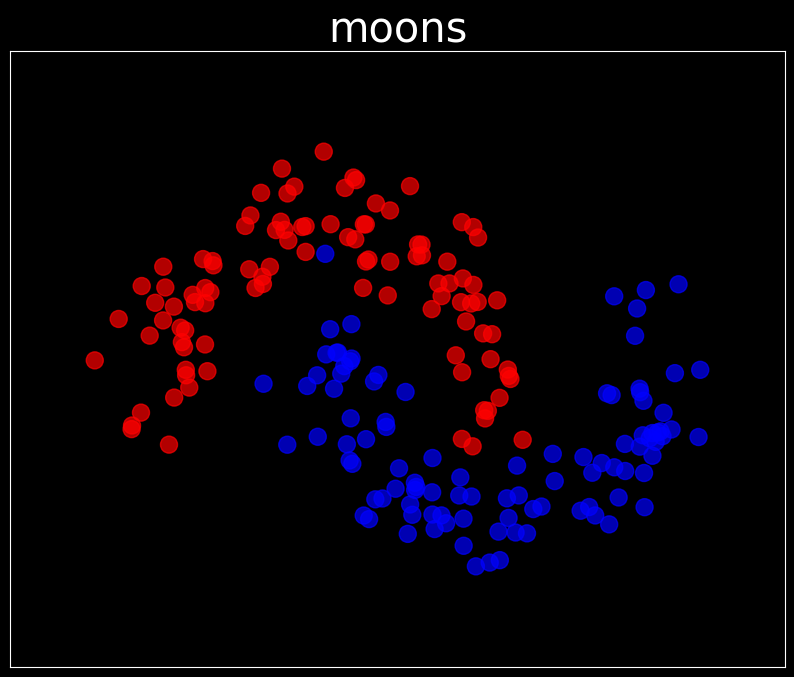

In [ ]:
X,y = make_binary_clf(N,method = 'moons')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'moons')


Получается имеем довольно замысловатую структуру, которую с первого раза не понять, как разделить, но посмотрим, что можно сделать


## Полинамиальная регрессия  

In [ ]:
def to_polynom(X, order = 2):
    """Генерация полиномиальных признаков .
    Входные переменные:
    ===========
    X: признаки
    order: порядок полинома
    """
    if order <2: # чтобы не пытались вставить отрицательные степени
        order = 2

    order_range = range(2, order+1,1)
    out = np.copy(X)
    for i in order_range:
        out = np.hstack([out, np.power(X,i)]) # складываем в выходную переменную все степени от 2 до order
    return out

Понятно, что обычная логистическая регрессия вряд ли справится, поэтому заведем полиномиальную регрессию

In [ ]:
X_poly   = to_polynom(X, order = 2)  # из исходых данных генерируем полиномы второй степени

#  не забываем хотя бы разделять на тренировочную и тестовую (валидационную)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)


Разделим данные на тестовую и тренировочную, с полиномом степени 2

In [ ]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

0.85 0.8428571428571429
True Positives:0.9130	False Positives:0.0870
False Negatives:0.1892	True Negatives:0.8108
Accuracy:0.8500
Recall:0.7500	Precision:0.9130
f1 measure:0.8235


Ну по метрикам вроде как все и нормально, но стоит посмотреть, чего там происходит на графиках

In [ ]:
w, b = regr.get_w_and_b()
print(w,b)

[ 1.06484178 -4.59396921  0.13493658 -0.03868902] 0.4419607723340496


In [ ]:
vis_weigths(np.hstack([b,w]))

Явно выделяется второй вес, довольно тяжелый

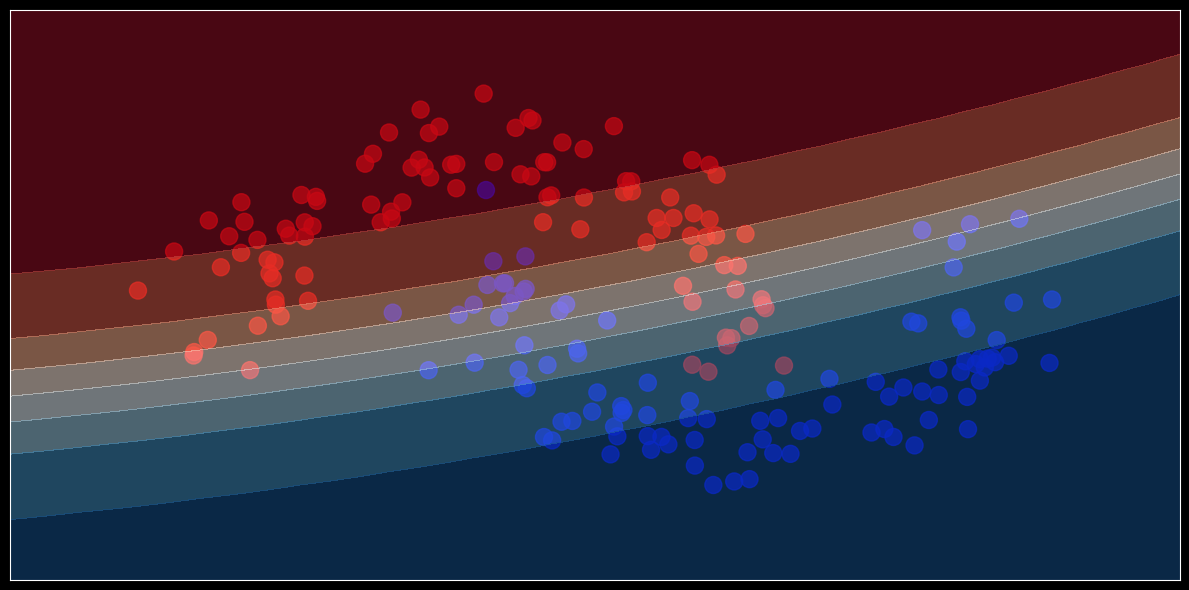

In [ ]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)


Но, как мы видим, вторая степень не справляется, попробуем степени повыше

In [ ]:
X_poly   = to_polynom(X, order = 4)  # из исходых данных генерируем полиномы второй степени

#  не забываем хотя бы разделять на тренировочную и тестовую (валидационную)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

In [ ]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

0.9833333333333333 0.9857142857142858
True Positives:1.0000	False Positives:0.0000
False Negatives:0.0303	True Negatives:0.9697
Accuracy:0.9833
Recall:0.9643	Precision:1.0000
f1 measure:0.9818


Confusion matrix, конечно уже немного другая, однако с accuracy 0.99 (немного настораживает) довольно неплохие результаты с TP И TN

In [ ]:
w, b = regr.get_w_and_b()
print(w,b)

[-0.5679474  -6.24308322 -8.7833133   0.63872589  2.05465396 -2.85413325
  2.44229434 -1.02266269] 4.03327446076711


In [ ]:
vis_weigths(np.hstack([b,w]))

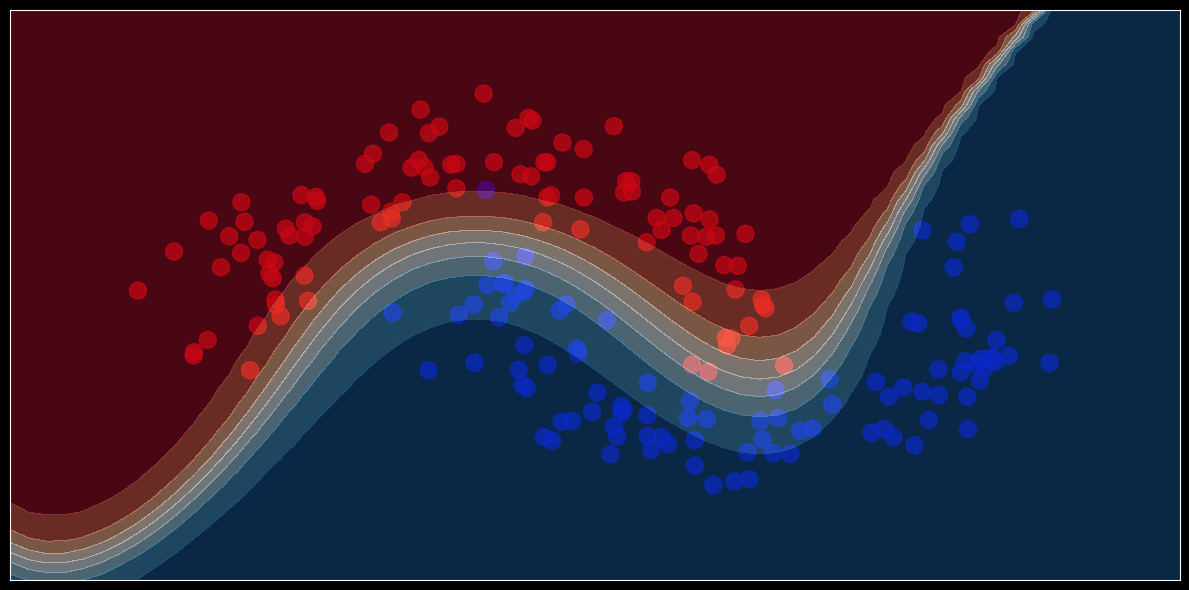

In [ ]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 4)


И как мы видим, вполне неплохой результат, довольно близкая к правде кривая, кажется, что четвертой степени полинома хватает, для правильной классификации

До кучи попробуем еще и 10-ю степень

In [ ]:
X_poly   = to_polynom(X, order = 10)  # из исходых данных генерируем полиномы второй степени

#  не забываем хотя бы разделять на тренировочную и тестовую (валидационную)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

In [ ]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

0.9833333333333333 0.9785714285714285
True Positives:1.0000	False Positives:0.0000
False Negatives:0.0303	True Negatives:0.9697
Accuracy:0.9833
Recall:0.9643	Precision:1.0000
f1 measure:0.9818


TP И TN почти по единице

In [ ]:
w, b = regr.get_w_and_b()
print(w,b)

[  4.0977437  -14.11535279  -4.76898035   1.95226542  -0.92657112
  -4.50804043  -7.78868881  -0.0603398   -3.19397689  -1.7229269
 -10.01225847  -0.50901869  -2.69091079  -1.36798642  -7.78147137
  -0.49508526   6.19014234  -0.50556875  11.54072956  -0.6464636 ] 8.111545953259638


In [ ]:
vis_weigths(np.hstack([b,w]))

Ну и весов побольше гораздо

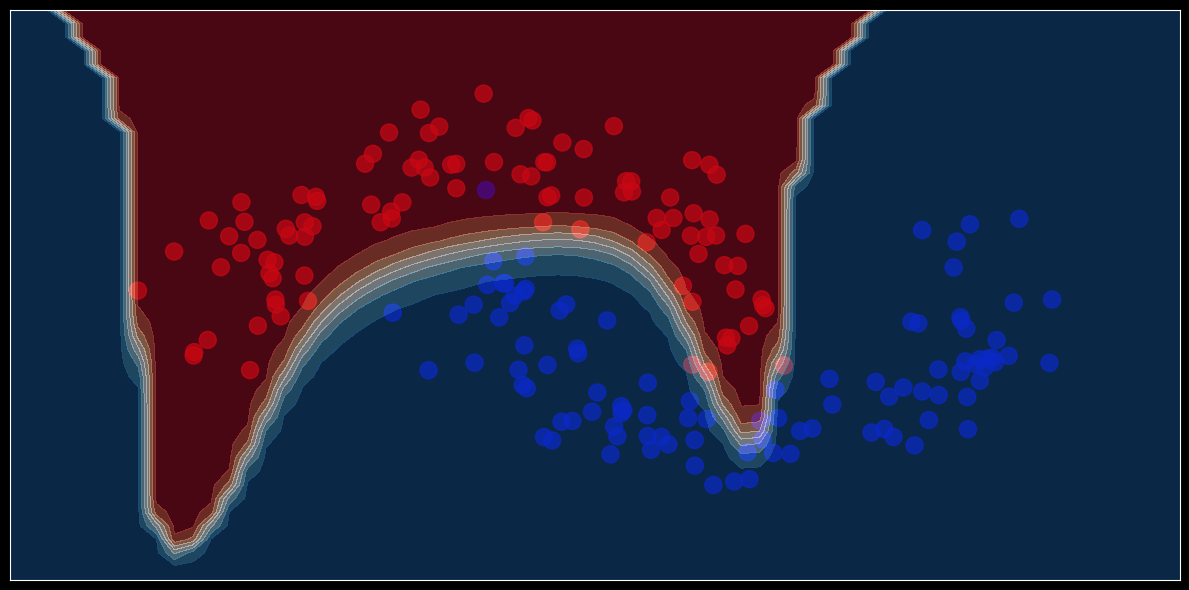

In [ ]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 10)


Ну тут вот уже вроде как уже и не совсем правдоподобная картина, кажется, что это из-за переобучения модели